<a href="https://colab.research.google.com/github/asadali163/NLP-Transformers/blob/main/codebase/NLP_Fine_Tuning_on_Custom_Data_intermediate.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install transformers datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.8/547.8 kB 14.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.1/316.1 kB 23.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 19.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 16.9 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.31.0
    Uninstalling requests-2.31.0:
      Successfully uninstalled requests-2.31.0
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 14.0.2
    Uninstalling pyarrow-14.0.2:
      Successfully uninstalled pyarrow-14.0.2
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.6.1
    Uninstalling fsspec-2024.6.1:
   

In [60]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix

from datasets import load_dataset, load_metric
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer

In [4]:
df = pd.read_csv('Tweets.csv')

In [5]:
df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [6]:
# We are only interested in text and sentiment
df = df[['text', 'airline_sentiment']].copy()

In [7]:
df.head()

,text,airline_sentiment
0,@VirginAmerica What @dhepburn said.,neutral
1,@VirginAmerica plus you've added commercials t...,positive
2,@VirginAmerica I didn't today... Must mean I n...,neutral
3,@VirginAmerica it's really aggressive to blast...,negative
4,@VirginAmerica and it's a really big bad thing...,negative


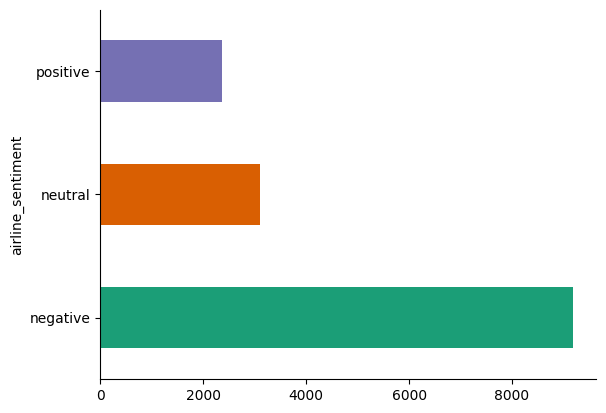

In [8]:
# @title airline_sentiment

from matplotlib import pyplot as plt
import seaborn as sns
df.groupby('airline_sentiment').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

As there are 3 labels, so we need to convert them into numbers.

In [9]:
labels = {'positive':0, 'negative':1, 'neutral':2}
df['target'] = df['airline_sentiment'].map(labels)

In [10]:
df.head()

,text,airline_sentiment,target
0,@VirginAmerica What @dhepburn said.,neutral,2
1,@VirginAmerica plus you've added commercials t...,positive,0
2,@VirginAmerica I didn't today... Must mean I n...,neutral,2
3,@VirginAmerica it's really aggressive to blast...,negative,1
4,@VirginAmerica and it's a really big bad thing...,negative,1


In [11]:
# Take only text and target
df = df[['text', 'target']].copy()
df.columns = ['sentence', 'label']
df.head()

,sentence,label
0,@VirginAmerica What @dhepburn said.,2
1,@VirginAmerica plus you've added commercials t...,0
2,@VirginAmerica I didn't today... Must mean I n...,2
3,@VirginAmerica it's really aggressive to blast...,1
4,@VirginAmerica and it's a really big bad thing...,1


In [12]:
# Now save the data so that we can load it with dataset from transformer
df.to_csv('data.csv', index=False)

In [13]:
dataset = load_dataset('csv', data_files='data.csv')

Generating train split: 0 examples [00:00, ? examples/s]

In [14]:
dataset

DatasetDict({
    train: Dataset({
        features: ['sentence', 'label'],
        num_rows: 14640
    })
})

As this has only train data, so we need to split it into train and test

In [16]:
split = dataset['train'].train_test_split(test_size=0.2, seed=42)

In [17]:
split

DatasetDict({
    train: Dataset({
        features: ['sentence', 'label'],
        num_rows: 11712
    })
    test: Dataset({
        features: ['sentence', 'label'],
        num_rows: 2928
    })
})

In [22]:
split['train'][0]

{'sentence': '@JetBlue Thanks for the personalized customer service! #cannedtweet #autoresponse',
 'label': 0}

In [24]:
split['test'].features

{'sentence': Value(dtype='string', id=None),
 'label': Value(dtype='int64', id=None)}

Now our data is in the format we need it to be

In [19]:
# Now work on model itself from now
checkpoint = 'distilbert-base-uncased'
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [20]:
tokenizer

DistilBertTokenizerFast(name_or_path='distilbert-base-uncased', vocab_size=30522, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True),  added_tokens_decoder={
	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	100: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	101: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	102: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	103: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}

In [25]:
# Let's have tokenizer function
def tokenize_function(examples):
  return tokenizer(examples['sentence'], truncation=True)

In [26]:
tokenized_datasets = split.map(tokenize_function, batched=True)

Map:   0%|          | 0/11712 [00:00<?, ? examples/s]

Map:   0%|          | 0/2928 [00:00<?, ? examples/s]

In [27]:
tokenized_datasets

DatasetDict({
    train: Dataset({
        features: ['sentence', 'label', 'input_ids', 'attention_mask'],
        num_rows: 11712
    })
    test: Dataset({
        features: ['sentence', 'label', 'input_ids', 'attention_mask'],
        num_rows: 2928
    })
})

In [28]:
tokenized_datasets['train'][0]

{'sentence': '@JetBlue Thanks for the personalized customer service! #cannedtweet #autoresponse',
 'label': 0,
 'input_ids': [101,
  1030,
  6892,
  16558,
  5657,
  4283,
  2005,
  1996,
  3167,
  3550,
  8013,
  2326,
  999,
  1001,
  27141,
  2102,
  28394,
  2102,
  1001,
  8285,
  6072,
  26029,
  3366,
  102],
 'attention_mask': [1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1]}

In [31]:
# Let's define some of the training arguments
training_args = TrainingArguments(
    output_dir='my_trained_model',
    num_train_epochs=3,
    eval_strategy='epoch',
    save_strategy='epoch',
    per_device_train_batch_size=16,
    per_device_eval_batch_size=64
)

In [32]:
model = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=3)

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [33]:
type(model)

transformers.models.distilbert.modeling_distilbert.DistilBertForSequenceClassification

In [34]:
!pip install torchinfo

In [35]:
# print summary
from torchinfo import summary
summary(model)

Layer (type:depth-idx)                                  Param #
DistilBertForSequenceClassification                     --
├─DistilBertModel: 1-1                                  --
│    └─Embeddings: 2-1                                  --
│    │    └─Embedding: 3-1                              23,440,896
│    │    └─Embedding: 3-2                              393,216
│    │    └─LayerNorm: 3-3                              1,536
│    │    └─Dropout: 3-4                                --
│    └─Transformer: 2-2                                 --
│    │    └─ModuleList: 3-5                             42,527,232
├─Linear: 1-2                                           590,592
├─Linear: 1-3                                           2,307
├─Dropout: 1-4                                          --
Total params: 66,955,779
Trainable params: 66,955,779
Non-trainable params: 0

As you can see all are the trainable parameters

In [36]:
def compute_logits(logits_and_labels):
  logits, labels = logits_and_labels
  predictions = np.argmax(logits, axis=-1)
  acc = np.mean(predictions == labels)
  f1_sc = f1_score(labels, predictions, average='macro')
  return {'accuracy':acc, 'f1_score':f1_sc}

In [37]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets['train'],
    eval_dataset=tokenized_datasets['test'],
    tokenizer=tokenizer,
    compute_metrics=compute_logits

)

In [38]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1 Score
1,0.541200,0.423394,0.841189,0.791366
2,0.365600,0.442118,0.848019,0.800984
3,0.169400,0.558101,0.842896,0.792777


TrainOutput(global_step=2196, training_loss=0.32487319901124156, metrics={'train_runtime': 226.0506, 'train_samples_per_second': 155.434, 'train_steps_per_second': 9.715, 'total_flos': 409439193244992.0, 'train_loss': 0.32487319901124156, 'epoch': 3.0})

As you can see our model overfit on third epoch, so we will only load upto the second epoch.

In [39]:
!ls my_trained_model

checkpoint-1464  checkpoint-2196  checkpoint-732  runs


we will load the checkpoint 2196

In [40]:
from transformers import pipeline

In [42]:
my_model = pipeline('text-classification', model='my_trained_model/checkpoint-2196', device=0)

In [43]:
split['test']

Dataset({
    features: ['sentence', 'label'],
    num_rows: 2928
})

This is our test data

In [44]:
preds = my_model(split['test']['sentence'])

In [46]:
preds

[{'label': 'LABEL_0', 'score': 0.9682137966156006},
 {'label': 'LABEL_0', 'score': 0.9454600811004639},
 {'label': 'LABEL_1', 'score': 0.9030579924583435},
 {'label': 'LABEL_0', 'score': 0.8972596526145935},
 {'label': 'LABEL_0', 'score': 0.8140524625778198},
 {'label': 'LABEL_1', 'score': 0.9977510571479797},
 {'label': 'LABEL_2', 'score': 0.9820361733436584},
 {'label': 'LABEL_2', 'score': 0.9741495251655579},
 {'label': 'LABEL_0', 'score': 0.7433480024337769},
 {'label': 'LABEL_1', 'score': 0.9982799291610718},
 {'label': 'LABEL_1', 'score': 0.9972355961799622},
 {'label': 'LABEL_1', 'score': 0.9970909357070923},
 {'label': 'LABEL_0', 'score': 0.9863128066062927},
 {'label': 'LABEL_1', 'score': 0.9981034994125366},
 {'label': 'LABEL_2', 'score': 0.9884527325630188},
 {'label': 'LABEL_0', 'score': 0.9569898247718811},
 {'label': 'LABEL_2', 'score': 0.6885290145874023},
 {'label': 'LABEL_1', 'score': 0.9984135627746582},
 {'label': 'LABEL_1', 'score': 0.9890106320381165},
 {'label': '

In [47]:
def get_label(pred):
  return pred['label'].split('_')[1]

In [53]:
pred_labels = [int(get_label(pred)) for pred in preds]

In [54]:
pred_labels[:10]

[0, 0, 1, 0, 0, 1, 2, 2, 0, 1]

Now we can compute the accuracy and f1 score, note that this should match the numbers from train on epoch 2

In [56]:
acc = accuracy_score(split['test']['label'], pred_labels)
f1 = f1_score(split['test']['label'], pred_labels, average='macro')

In [57]:
acc, f1

(0.842896174863388, 0.7927766858334766)

As this match exactly the above

now let's plot the confusion matrix

In [63]:
def plot_confusion_matrix(cm):
  classes = ['positive', 'negative', 'neutral']
  df_cm = pd.DataFrame(cm, index=classes, columns=classes)
  plt.figure(figsize=(10,7))
  sns.heatmap(df_cm, annot=True, fmt='g')
  plt.title('Confusion Matrix')
  plt.ylabel('True label')
  plt.xlabel('Predicted label')




In [68]:
cm = confusion_matrix(split['test']['label'], pred_labels, normalize='true')

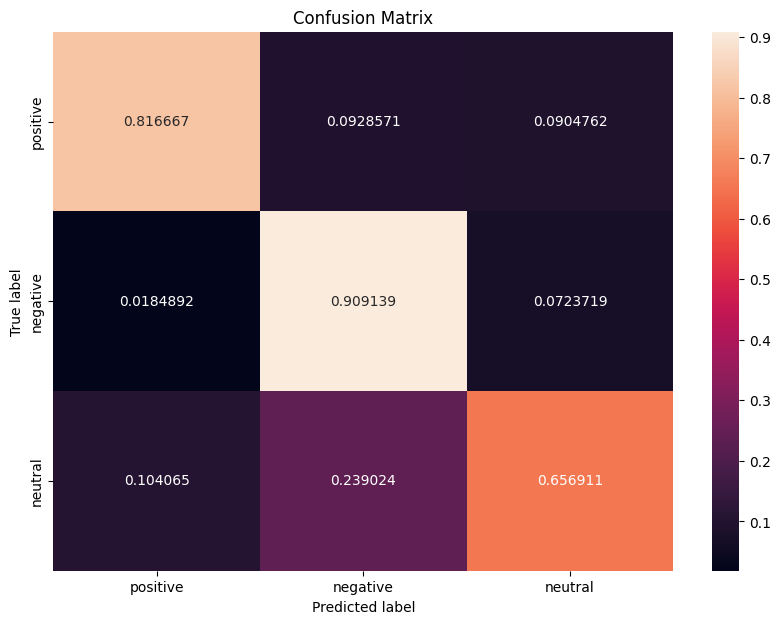

In [69]:
plot_confusion_matrix(cm)

As you can see we have error in predicting the neutral class